# Example Bokeh Interactive for Light Curves

*Author: Aaron Geller*

*June 14, 2018*

### Import libraries 

In [1]:
from astropy.table import Table
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
from astropy.stats import LombScargle
from scipy.signal import argrelextrema
%matplotlib notebook

In [2]:
from bokeh.plotting import *
from bokeh.layouts import row, widgetbox
from bokeh.models import ColumnDataSource, CustomJS, Slider, Select, Button
from bokeh.events import DoubleTap

### Read in the light curve data file

In [3]:
filename = "data/27882110006813.ipac_tbl"
ipac_lc = Table.read(filename, format='ipac')

hjd = np.array(ipac_lc["obsmjd"])
mag = np.array(ipac_lc["mag_autocorr"])
mag_unc = np.array(ipac_lc["magerr_auto"])

mmag = np.mean(mag) - mag

### Plot the time-series data

Text(0,0.5,'<mag> - mag')

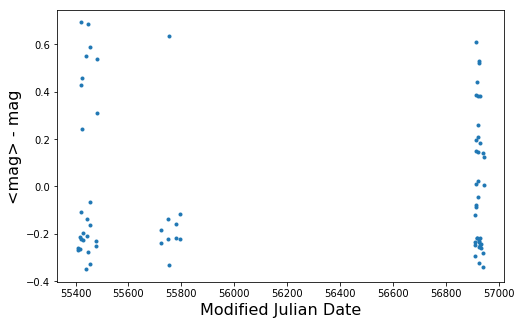

In [4]:
f, ax = plt.subplots(figsize=(8,5))
ax.plot(hjd, mmag,'.' )
ax.set_xlabel('Modified Julian Date', fontsize=16)
ax.set_ylabel('<mag> - mag', fontsize=16)

### Calculate and plot the Lomb Scargle periodogram

best period 0.4661477095501411


Text(0,0.5,'power')

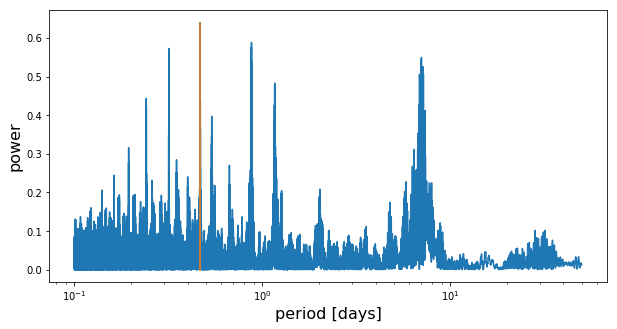

In [5]:
# Note: these are all in units of days
pmin = 0.1
pmax = 50.
ls = LombScargle(hjd, mag)
frequency, power = ls.autopower(maximum_frequency=1./pmin, minimum_frequency=1./pmax)
best_frequency = frequency[np.argmax(power)]
period = 1./frequency
best_period = 1./best_frequency
print("best period", best_period)

f, ax = plt.subplots(figsize=(10,5))
ax.plot(period, power) 
ax.plot(np.full(2, best_period), [0,np.max(power)])
ax.set_xscale('log')
ax.set_xlabel('period [days]', fontsize=16)
ax.set_ylabel('power', fontsize=16)

### Plot the phased light curve

Text(0,0.5,'<mag> - mag')

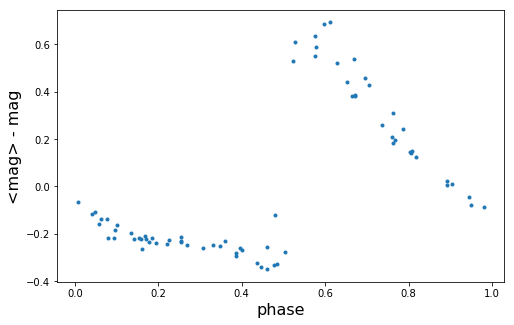

In [6]:
f, ax = plt.subplots(figsize=(8,5))
phase = (hjd % best_period) / best_period
ax.plot(phase, mmag,'.' )
ax.set_xlabel('phase', fontsize=16)
ax.set_ylabel('<mag> - mag', fontsize=16)

### Pick out some of the peaks to look examine interactively

*Get the harmonics f/2, f/3*

In [7]:
htests = np.array([best_frequency, best_frequency/2., best_frequency/3.])

*Get a few common failures : frequency +/- integers (for a typical 1 day observing cadence) *

In [8]:
ftests = np.array([])
rng = np.array([1, 2])
for i in rng:
    hm = [htests + i, htests - i]
    ftests = np.append(ftests, hm)
ftests = np.unique(ftests) #also sorts
useit = np.where(ftests > 0)
ftests = ftests[useit]

*Simply get some of the top maxima, but exclude any that have a high false-alarm probability*

In [9]:
spacing = 50 # number of neighboring points to consider for finding relative maxima
alarm = 1e-4 # maximum of false alarm probability to accept
posall = argrelextrema(power, np.greater, order=spacing)[0] #get all maxima
fx = frequency[posall]
powx = power[posall]

# test the false-alarm probability
falarm = ls.false_alarm_probability(powx)
useit = np.where(falarm < alarm)
ftests2 = fx[useit]

*Sort these in order of importance for the user.  I will keep the best fit and harmonics first, then append a combined list of these last two sorted by power*

In [10]:
# combine the common failures and extra maxima
ftAll = np.append(ftests, ftests2)
ptAll = np.interp(ftAll, frequency, power)
ft, fi = np.unique(ftAll, return_index=True)
pt = ptAll[fi]
sp = np.argsort(pt)
sp = sp[::-1]
ft = ft[sp]
# remove the harmonics from this list
ft1 = np.array([])
for f in ft:
    test = np.where(htests == f)[0]
    if (len(test) == 0):
        ft1 = np.append(ft1, f)
        
# now prepend the harmonics 
ftest_final = np.append(htests, ft1)
ptest_final = 1/ftest_final

print(ptest_final)


[ 0.46614771  0.93229542  1.39844313  0.87527406  0.3176634   0.87317731
  7.01791922  0.31794048  1.16333985  0.24108044  0.53752377  6.88502467
  0.24124039  0.58306287 13.77004933  0.36831315  0.48248079  0.325455  ]


*Now plot these to check.*

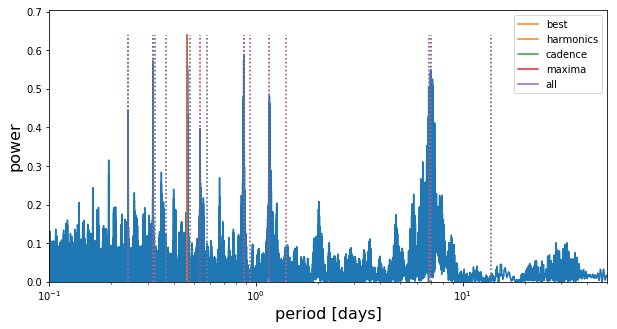

In [11]:
# remake the periodogram plot
f, ax = plt.subplots(figsize=(10,5))
ax.plot(period, power) 
ax.plot(np.full(2, best_period), [0,np.max(power)], label='best')
ax.set_xscale('log')
ax.set_xlabel('period [days]', fontsize=16)
ax.set_ylabel('power', fontsize=16)
ax.set_xlim(pmin, pmax)
ax.set_ylim(0, 1.1*np.max(power))

# plot the harmonics on top
ax.plot(1e10, 1e10, color='C1', label='harmonics')
for fr in htests:
    ax.plot(np.full(2, 1./fr), [0,np.max(power)], ':', color='C1')

# plot the common failures from cadence next
ax.plot(1e10, 1e10, color='C2', label='cadence')
for fr in ftests:
    ax.plot(np.full(2, 1./fr), [0,np.max(power)], ':', color='C2')

# plot the additional maxima next
ax.plot(1e10, 1e10, color='C3', label='maxima')
for fr in ftests2:
    ax.plot(np.full(2, 1./fr), [0,np.max(power)], ':', color='C3')

# plot the combined list on top (if all went well, this is all that we will see)
ax.plot(1e10, 1e10, color='C4', label='all')
for p in ptest_final:
    ax.plot(np.full(2, p), [0,np.max(power)], ':', color='C4')

ax.legend()


## Build the Bokeh interactive demo

*This cell below controls whether the demo produces an html file, or simply runs in the notebook*

In [12]:
output_notebook() # run in the notebook
#output_file("LC_Bokeh_Demo.html", title='LC Bokeh Demo') # produce an html file

Loading BokehJS ...

In [13]:
# create a column data source for the plots to share
LC_source = ColumnDataSource(data=dict(hjd=hjd, phase=phase, mag=mmag, ))

P_source = ColumnDataSource(data=dict(period=period, power=power,))

bpx = np.full(2, best_period)
bpy = np.array([0,np.max(power)])
BP_source = ColumnDataSource(data=dict(bpx=bpx, bpy=bpy))

popts = [str(x) for x in ptest_final]
PO_source = ColumnDataSource(data=dict(popts=popts))

# define the tools to include
TOOLS = "pan,wheel_zoom,box_zoom,reset"

# create the plots
rawLC = figure(tools=TOOLS, width=400, height=200, title=None)
rawLC.circle('hjd', 'mag', source=LC_source, color='crimson')
rawLC.xaxis.axis_label = "Days"
rawLC.yaxis.axis_label = "Brightness"

phaseLC = figure(tools=TOOLS, width=400, height=200, title=None)
phaseLC.circle('phase', 'mag', source=LC_source, color='crimson')
phaseLC.xaxis.axis_label = "Phase"
phaseLC.yaxis.axis_label = "Brightness"

pdgm = figure(tools=TOOLS, width=400, height=200, title=None,  x_axis_type="log")
pdgm.line('period', 'power', source=P_source, color='steelblue', line_width=1)
pdgm.line('bpx', 'bpy', source=BP_source, color='crimson', line_width=3, line_alpha=0.5)
pdgm.xaxis.axis_label = "Period [days]"
pdgm.yaxis.axis_label = "Power"

# If the user double clicks in the periodogram, print the best period
pdgm2clicks = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source), code="""
    var best_period = cb_obj.x;

    pslider.value = best_period;
    pslider.start = best_period/2.;
    pslider.end = best_period*2.;
        
    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();
""")
pdgm.js_on_event(DoubleTap, pdgm2clicks)


# define the widgets
# Lots of this code is redundant, but I couldn't figure out a good way to identify which widget executed the callback
sliderCallback = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source), code="""
    var best_period = pslider.value;
    
    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();

""")

selectCallback = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source), code="""
    var best_period = pselect.value;
    pslider.value = best_period;
    pslider.start = best_period/2.;
    pslider.end = best_period*2.;

    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();
""")

PbuttonCallback = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source, PO_source=PO_source), code="""
    //increase the index of the best_period by 1
    var select_period = parseFloat(pselect.value);
    var ii = PO_source.data.popts.map( function(value) { 
        return Math.abs(value - select_period); 
    } );
    inow = ii.indexOf(Math.min.apply(Math, ii))
    var i = Math.min( inow+1, PO_source.data.popts.length-1);
    best_period = PO_source.data.popts[i];
    
    pslider.value = best_period;
    pslider.start = best_period/2.;
    pslider.end = best_period*2.;
    
    pselect.value = best_period;
    
    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();

""")

MbuttonCallback = CustomJS(args=dict(LC_source=LC_source, BP_source=BP_source, PO_source=PO_source), code="""
    //decrease the index of the best_period by 1
    var select_period = parseFloat(pselect.value);
    var ii = PO_source.data.popts.map( function(value) { 
        return Math.abs(value - select_period); 
    } );
    inow = ii.indexOf(Math.min.apply(Math, ii))
    var i = Math.max( inow-1, 0);
    best_period = PO_source.data.popts[i];
    
    pslider.value = best_period;
    pslider.start = best_period/2.;
    pslider.end = best_period*2.;
    
    pselect.value = best_period;
    
    var LCdata = LC_source.data;
    var BPdata = BP_source.data;
    var phase = LCdata['phase'];
    var hjd = LCdata['hjd'];
    for (i = 0; i < phase.length; i++) {
       phase[i] = (hjd[i] % best_period) / best_period;
    }

    var bpx = BPdata['bpx'];
    for (i = 0; i < bpx.length; i++) {
       bpx[i] = best_period;
    }
    LC_source.change.emit();
    BP_source.change.emit();


""")

# period slider
period_slider = Slider(start=best_period/2., end=best_period*2., value=best_period, step=1e-5,
                    title="Period", callback=sliderCallback)
sliderCallback.args["pslider"] = period_slider
selectCallback.args["pslider"] = period_slider
PbuttonCallback.args["pslider"] = period_slider
MbuttonCallback.args["pslider"] = period_slider
pdgm2clicks.args["pslider"] = period_slider

# period dropdown
i = int(np.where(ptest_final == best_period)[0])
select = Select(title="Periods", value=popts[i], options=popts, callback=selectCallback)
sliderCallback.args["pselect"] = select
selectCallback.args["pselect"] = select
PbuttonCallback.args["pselect"] = select
MbuttonCallback.args["pselect"] = select

# buttons
Pbutton = Button(label=">", button_type="success", callback=PbuttonCallback)
Mbutton = Button(label="<", button_type="success", callback=MbuttonCallback)

# put the subplots in a gridplot
w = widgetbox(period_slider, select, Pbutton, Mbutton, width=200, height=200,)
p = gridplot( [ 
    [rawLC, w], 
    [phaseLC, None ],
    [pdgm, None]])
l = row(p)

show(l)